<a name="1"></a>
# **<h1 id="1" style="background-color:#F0EFEB;font-family:newtimeroman;font-size:150%;color:#283618;text-align:center;border-radius:15px 15px;padding:7px;border:solid 3px #B7B7A4;">Utils</h1>**

In [1]:
import torch
import json
import matplotlib.pyplot as plt

configs = {
    "train_source_data":"/kaggle/input/data-en-vi/train.en", 
    "train_target_data":"/kaggle/input/data-en-vi/train.vi", 
    "valid_source_data":"/kaggle/input/data-en-vi/tst2013.en",  
    "valid_target_data":"/kaggle/input/data-en-vi/tst2013.vi",  
    "source_tokenizer":"bert-base-uncased",  # PhoBERT for Vietnamese
    "target_tokenizer":"vinai/phobert-base",  # BERT for English
    "source_max_seq_len":128,  # Decrease sequence length
    "target_max_seq_len":128,  # Decrease sequence length
    "batch_size":10,  # Increase batch size
    "device":"cuda:0" if torch.cuda.is_available() else "cpu",
    "embedding_dim": 256,  # Reduce embedding dimension
    "n_layers": 4,  # Reduce number of layers
    "n_heads": 4,  # Reduce number of heads
    "dropout": 0.1,
    "lr":0.0001,  # Increase learning rate
    "n_epochs":30,  # Increase number of epochs
    "print_freq": 5,
    "beam_size":3,
    "early_stopping":5
}

<a name="1"></a>
# **<h1 id="1" style="background-color:#F0EFEB;font-family:newtimeroman;font-size:150%;color:#283618;text-align:center;border-radius:15px 15px;padding:7px;border:solid 3px #B7B7A4;">Datasets</h1>**

In [10]:
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModel
import re

class TranslateDataset(Dataset):
    def __init__(self, source_tokenizer, target_tokenizer, source_data=None, target_data=None, source_max_seq_len=256, target_max_seq_len=256, phase="train"):
        self.source_data = source_data
        self.target_data = target_data
        self.source_tokenizer = source_tokenizer
        self.target_tokenizer = target_tokenizer
        self.source_max_seq_len = source_max_seq_len
        self.target_max_seq_len = target_max_seq_len
        self.phase = phase
    
    def preprocess_seq(self, seq):
        seq = re.sub(
        r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(seq))
        seq = re.sub(r"[ ]+", " ", seq)
        seq = re.sub(r"\!+", "!", seq)
        seq = re.sub(r"\,+", ",", seq)
        seq = re.sub(r"\?+", "?", seq)
        seq = seq.lower()
        return seq
    
    def __len__(self):
        return len(self.source_data)
    
    def __getitem__(self, index):        
        source = self.source_tokenizer(
                text=self.preprocess_seq(self.source_data[index]),
                padding="max_length", 
                max_length=self.source_max_seq_len, 
                truncation=True, 
                return_tensors="pt"
            )
        
        if self.phase == "train":
            target = self.target_tokenizer(
                text=self.preprocess_seq(self.target_data[index]),
                padding="max_length",
                max_length=self.target_max_seq_len,
                truncation=True,
                return_tensors="pt"
            )

            return {
                "source_seq": self.source_data[index],
                "source_ids": source["input_ids"][0],
                "target_seq": self.target_data[index],
                "target_ids": target["input_ids"][0],
                }
        else:
            return {
                "source_seq": self.source_data[index],
                "source_ids": source["input_ids"][0],
            }


def read_data(source_file, target_file):
    source_data = open(source_file).read().strip().split("\n")
    target_data = open(target_file).read().strip().split("\n")
    return source_data, target_data


<a name="1"></a>
# **<h1 id="1" style="background-color:#F0EFEB;font-family:newtimeroman;font-size:150%;color:#283618;text-align:center;border-radius:15px 15px;padding:7px;border:solid 3px #B7B7A4;">Building Model</h1>**

In [11]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.autograd import Variable

# Embedding the input sequence
class Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Embedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

# The positional encoding vector
class PositionalEncoder(nn.Module):
    def __init__(self, embedding_dim, max_seq_length=512, dropout=0.1):
        super(PositionalEncoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_seq_length, embedding_dim)
        for pos in range(max_seq_length):
            for i in range(0, embedding_dim, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/embedding_dim)))
                pe[pos, i+1] = math.cos(pos/(10000**((2*i+1)/embedding_dim)))
        pe = pe.unsqueeze(0)        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x*math.sqrt(self.embedding_dim)
        seq_length = x.size(1)
        pe = Variable(self.pe[:, :seq_length], requires_grad=False).to(x.device)
        # Add the positional encoding vector to the embedding vector
        x = x + pe
        x = self.dropout(x)
        return x

# Self-attention layer
class SelfAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, dropout=0.1):
        super(SelfAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        key_dim = key.size(-1)
        attn = torch.matmul(query / np.sqrt(key_dim), key.transpose(2, 3))
        if mask is not None:
            mask = mask.unsqueeze(1)
            attn = attn.masked_fill(mask == 0, -1e9)
        attn = self.dropout(torch.softmax(attn, dim=-1))
        output = torch.matmul(attn, value)

        return output
        
# Multi-head attention layer
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.self_attention = SelfAttention(dropout)
        # The number of heads
        self.num_heads = num_heads
        # The dimension of each head
        self.dim_per_head = embedding_dim // num_heads
        # The linear projections
        self.query_projection = nn.Linear(embedding_dim, embedding_dim)
        self.key_projection = nn.Linear(embedding_dim, embedding_dim)
        self.value_projection = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, query, key, value, mask=None):
        # Apply the linear projections
        batch_size = query.size(0)
        query = self.query_projection(query)
        key = self.key_projection(key)
        value = self.value_projection(value)
        # Reshape the input
        query = query.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        # Calculate the attention
        scores = self.self_attention(query, key, value, mask)
        # Reshape the output
        output = scores.transpose(1, 2).contiguous().view(batch_size, -1, self.embedding_dim)
        # Apply the linear projection
        output = self.out(output)
        return output

# Norm layer
class Norm(nn.Module):
    def __init__(self, embedding_dim):
        super(Norm, self).__init__()
        self.norm = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        return self.norm(x)


# Transformer encoder layer
# class EncoderLayer(nn.Module):
#     def __init__(self, embedding_dim, num_heads, ff_dim=2048, dropout=0.1):
#         super(EncoderLayer, self).__init__()
#         self.self_attention = MultiHeadAttention(embedding_dim, num_heads, dropout)
#         self.feed_forward = nn.Sequential(
#             nn.Linear(embedding_dim, ff_dim),
#             nn.ReLU(),
#             nn.Linear(ff_dim, embedding_dim)
#         )
#         self.dropout1 = nn.Dropout(dropout)
#         self.dropout2 = nn.Dropout(dropout)
#         self.norm1 = Norm(embedding_dim)
#         self.norm2 = Norm(embedding_dim)

#     def forward(self, x, mask=None):
#         x2 = self.norm1(x)
#         # Add and Muti-head attention
#         x = x + self.dropout1(self.self_attention(x2, x2, x2, mask))
#         x2 = self.norm2(x)
#         x = x + self.dropout2(self.feed_forward(x2))
#         return x

# Transformer decoder layer
class DecoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim=2048, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(embedding_dim, num_heads, dropout)
        self.encoder_attention = MultiHeadAttention(embedding_dim, num_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embedding_dim)
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.norm1 = Norm(embedding_dim)
        self.norm2 = Norm(embedding_dim)
        self.norm3 = Norm(embedding_dim)

    def forward(self, x, memory, source_mask, target_mask):
        x2 = self.norm1(x)
        x = x + self.dropout1(self.self_attention(x2, x2, x2, target_mask))
        x2 = self.norm2(x)
        x = x + self.dropout2(self.encoder_attention(x2, memory, memory, source_mask))
        x2 = self.norm3(x)
        x = x + self.dropout3(self.feed_forward(x2))
        return x

# Encoder transformer
# class Encoder(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, max_seq_len, num_heads, num_layers, dropout=0.1):
#         super(Encoder, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.num_layers = num_layers
#         self.num_heads = num_heads
#         self.embedding_dim = embedding_dim
#         self.layers = nn.ModuleList([EncoderLayer(embedding_dim, num_heads, 2048, dropout) for _ in range(num_layers)])
#         self.norm = Norm(embedding_dim)
#         self.position_embedding = PositionalEncoder(embedding_dim, max_seq_len, dropout)
    
#     def forward(self, source, source_mask):
#         # Embed the source
#         x = self.embedding(source)
#         # Add the position embeddings
#         x = self.position_embedding(x)
#         # Propagate through the layers
#         for layer in self.layers:
#             x = layer(x, source_mask)
#         # Normalize
#         x = self.norm(x)
#         return x

# Decoder transformer
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_seq_len,num_heads, num_layers, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.layers = nn.ModuleList([DecoderLayer(embedding_dim, num_heads, 2048, dropout) for _ in range(num_layers)])
        self.norm = Norm(embedding_dim)
        self.position_embedding = PositionalEncoder(embedding_dim, max_seq_len, dropout)
    
    def forward(self, target, memory, source_mask, target_mask):
        # Embed the source
        x = self.embedding(target)
        # Add the position embeddings
        x = self.position_embedding(x)
        # Propagate through the layers
        for layer in self.layers:
            x = layer(x, memory, source_mask, target_mask)
        # Normalize
        x = self.norm(x)
        return x


# Transformers
class Transformer(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, source_max_seq_len, target_max_seq_len, embedding_dim, num_heads, num_layers, dropout=0.1):
        super(Transformer, self).__init__()
        self.source_vocab_size = source_vocab_size
        self.target_vocab_size = target_vocab_size
        self.source_max_seq_len = source_max_seq_len
        self.target_max_seq_len = target_max_seq_len
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout = dropout

        # self.encoder = Encoder(vocab_size, embedding_dim, max_seq_len, num_heads, num_layers, dropout)
        self.encoder = AutoModel.from_pretrained("google-bert/bert-base-uncased")
        self.decoder = Decoder(target_vocab_size, embedding_dim, target_max_seq_len, num_heads, num_layers, dropout)
        self.final_linear = nn.Linear(embedding_dim, target_vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, source, target, source_mask, target_mask):
        # Encoder forward pass
        memory = self.encoder(source, source_mask)
        # Decoder forward pass
        output = self.decoder(target, memory, source_mask, target_mask)
        # Final linear layer
        output = self.dropout(output)
        output = self.final_linear(output)
        return output
    
    def make_source_mask(self, source_ids, source_pad_id):
        return (source_ids != source_pad_id).unsqueeze(-2)

    def make_target_mask(self, target_ids):
        batch_size, len_target = target_ids.size()
        subsequent_mask = (1 - torch.triu(torch.ones((1, len_target, len_target), device=target_ids.device), diagonal=1)).bool()
        return subsequent_mask

In [18]:
sum([p.numel() for p in model.parameters()])

148629760

In [19]:
model

Transformer(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

<a name="2"></a>
# **<h1 id="2" style="background-color:#F0EFEB;font-family:newtimeroman;font-size:150%;color:#283618;text-align:center;border-radius:15px 15px;padding:7px;border:solid 3px #B7B7A4;">Training</h1>**

Validating epoch 1/30: 100%|██████████| 127/127 [00:04<00:00, 27.75it/s, loss=3.93]


---- Detect improvement and save the best model ----
---- Epoch 1/30 | Train loss: 4.7715 | Valid loss: 3.8683 | Best Valid loss: 3.8683 | Best epoch: 1


Validating epoch 2/30: 100%|██████████| 127/127 [00:04<00:00, 27.71it/s, loss=3.29]


---- Detect improvement and save the best model ----
---- Epoch 2/30 | Train loss: 3.6524 | Valid loss: 3.1865 | Best Valid loss: 3.1865 | Best epoch: 2


Validating epoch 3/30: 100%|██████████| 127/127 [00:04<00:00, 27.48it/s, loss=2.9]


---- Detect improvement and save the best model ----
---- Epoch 3/30 | Train loss: 3.1818 | Valid loss: 2.8903 | Best Valid loss: 2.8903 | Best epoch: 3


Validating epoch 4/30: 100%|██████████| 127/127 [00:04<00:00, 27.43it/s, loss=2.7]


---- Detect improvement and save the best model ----
---- Epoch 4/30 | Train loss: 2.9046 | Valid loss: 2.6947 | Best Valid loss: 2.6947 | Best epoch: 4


Validating epoch 5/30: 100%|██████████| 127/127 [00:04<00:00, 27.59it/s, loss=2.5]


---- Detect improvement and save the best model ----
---- Epoch 5/30 | Train loss: 2.7156 | Valid loss: 2.5504 | Best Valid loss: 2.5504 | Best epoch: 5


Validating epoch 6/30: 100%|██████████| 127/127 [00:04<00:00, 27.52it/s, loss=2.49]


---- Detect improvement and save the best model ----
---- Epoch 6/30 | Train loss: 2.5783 | Valid loss: 2.4892 | Best Valid loss: 2.4892 | Best epoch: 6


Validating epoch 7/30: 100%|██████████| 127/127 [00:04<00:00, 27.60it/s, loss=2.4]


---- Detect improvement and save the best model ----
---- Epoch 7/30 | Train loss: 2.4966 | Valid loss: 2.4396 | Best Valid loss: 2.4396 | Best epoch: 7


Validating epoch 8/30: 100%|██████████| 127/127 [00:04<00:00, 26.26it/s, loss=2.39]


---- Detect improvement and save the best model ----
---- Epoch 8/30 | Train loss: 2.4220 | Valid loss: 2.4104 | Best Valid loss: 2.4104 | Best epoch: 8


Validating epoch 9/30: 100%|██████████| 127/127 [00:04<00:00, 27.87it/s, loss=2.3]


---- Detect improvement and save the best model ----
---- Epoch 9/30 | Train loss: 2.3631 | Valid loss: 2.3743 | Best Valid loss: 2.3743 | Best epoch: 9


Validating epoch 10/30: 100%|██████████| 127/127 [00:04<00:00, 27.74it/s, loss=2.23]


---- Detect improvement and save the best model ----
---- Epoch 10/30 | Train loss: 2.3124 | Valid loss: 2.3643 | Best Valid loss: 2.3643 | Best epoch: 10


Validating epoch 11/30: 100%|██████████| 127/127 [00:04<00:00, 27.61it/s, loss=2.22]


---- Detect improvement and save the best model ----
---- Epoch 11/30 | Train loss: 2.2704 | Valid loss: 2.3462 | Best Valid loss: 2.3462 | Best epoch: 11


Validating epoch 12/30: 100%|██████████| 127/127 [00:04<00:00, 27.81it/s, loss=2.22]


---- Detect improvement and save the best model ----
---- Epoch 12/30 | Train loss: 2.2339 | Valid loss: 2.3394 | Best Valid loss: 2.3394 | Best epoch: 12


Validating epoch 13/30: 100%|██████████| 127/127 [00:04<00:00, 27.78it/s, loss=2.14]


---- Detect improvement and save the best model ----
---- Epoch 13/30 | Train loss: 2.2009 | Valid loss: 2.3238 | Best Valid loss: 2.3238 | Best epoch: 13


Validating epoch 14/30: 100%|██████████| 127/127 [00:04<00:00, 27.92it/s, loss=2.24]


---- Epoch 14/30 | Train loss: 2.1707 | Valid loss: 2.3258 | Best Valid loss: 2.3238 | Best epoch: 13


Validating epoch 15/30: 100%|██████████| 127/127 [00:04<00:00, 27.87it/s, loss=2.17]


---- Detect improvement and save the best model ----
---- Epoch 15/30 | Train loss: 2.1445 | Valid loss: 2.3234 | Best Valid loss: 2.3234 | Best epoch: 15


Validating epoch 16/30: 100%|██████████| 127/127 [00:04<00:00, 27.74it/s, loss=2.21]


---- Detect improvement and save the best model ----
---- Epoch 16/30 | Train loss: 2.1206 | Valid loss: 2.3151 | Best Valid loss: 2.3151 | Best epoch: 16


Validating epoch 17/30: 100%|██████████| 127/127 [00:04<00:00, 27.69it/s, loss=2.12]


---- Detect improvement and save the best model ----
---- Epoch 17/30 | Train loss: 2.0958 | Valid loss: 2.3041 | Best Valid loss: 2.3041 | Best epoch: 17


Validating epoch 18/30: 100%|██████████| 127/127 [00:04<00:00, 28.05it/s, loss=2.17]


---- Epoch 18/30 | Train loss: 2.0736 | Valid loss: 2.3077 | Best Valid loss: 2.3041 | Best epoch: 17


Validating epoch 19/30: 100%|██████████| 127/127 [00:04<00:00, 27.80it/s, loss=2.19]


---- Detect improvement and save the best model ----
---- Epoch 19/30 | Train loss: 2.0542 | Valid loss: 2.2965 | Best Valid loss: 2.2965 | Best epoch: 19


Validating epoch 20/30: 100%|██████████| 127/127 [00:04<00:00, 27.71it/s, loss=2.22]


---- Epoch 20/30 | Train loss: 2.0348 | Valid loss: 2.3061 | Best Valid loss: 2.2965 | Best epoch: 19


Validating epoch 21/30: 100%|██████████| 127/127 [00:04<00:00, 26.85it/s, loss=2.14]


---- Epoch 21/30 | Train loss: 2.0169 | Valid loss: 2.3089 | Best Valid loss: 2.2965 | Best epoch: 19


Validating epoch 22/30: 100%|██████████| 127/127 [00:04<00:00, 27.41it/s, loss=2.16]


---- Epoch 22/30 | Train loss: 1.9973 | Valid loss: 2.3071 | Best Valid loss: 2.2965 | Best epoch: 19


Validating epoch 23/30: 100%|██████████| 127/127 [00:04<00:00, 27.92it/s, loss=2.14]


---- Epoch 23/30 | Train loss: 1.9838 | Valid loss: 2.3030 | Best Valid loss: 2.2965 | Best epoch: 19


Validating epoch 24/30: 100%|██████████| 127/127 [00:04<00:00, 26.86it/s, loss=2.19]


---- Early stopping ----
Model saved to /kaggle/working/transformer_model.pth


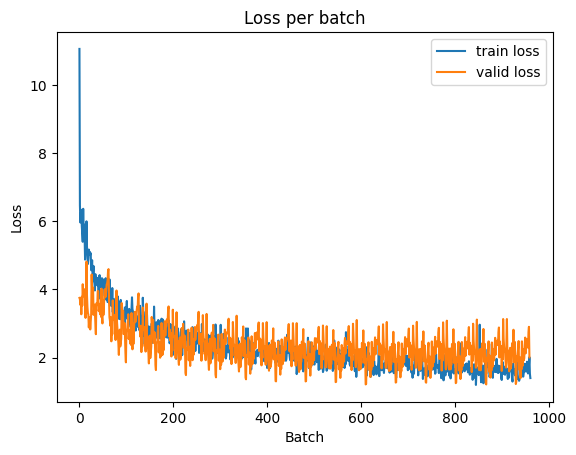

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer
from tqdm import tqdm
import numpy as np
import json
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from utils import configs, plot_loss
from datasets import TranslateDataset
from models import Transformer

def read_data(source_file, target_file):
    source_data = open(source_file).read().strip().split("\n")
    target_data = open(target_file).read().strip().split("\n")
    return source_data, target_data

def validate_epoch(model, valid_loader, epoch, n_epochs, source_pad_id, target_pad_id, device):
    model.eval()
    total_loss = []
    bar = tqdm(enumerate(valid_loader), total=len(valid_loader), desc=f"Validating epoch {epoch+1}/{n_epochs}")
    for i, batch in bar:
        source, target = batch["source_ids"].to(device), batch["target_ids"].to(device)
        target_input = target[:, :-1]
        source_mask, target_mask = model.make_source_mask(source, source_pad_id), model.make_target_mask(target_input)
        preds = model(source, target_input, source_mask, target_mask)
        gold = target[:, 1:].contiguous().view(-1)
        loss = F.cross_entropy(preds.view(-1, preds.size(-1)), gold, ignore_index=target_pad_id)
        total_loss.append(loss.item())
        bar.set_postfix(loss=total_loss[-1])

    valid_loss = sum(total_loss) / len(total_loss)
    return valid_loss, total_loss

def train_epoch(model, train_loader, optim, epoch, n_epochs, source_pad_id, target_pad_id, device):
    model.train()
    total_loss = []
    bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Training epoch {epoch+1}/{n_epochs}")
    for i, batch in bar:
        source, target = batch["source_ids"].to(device), batch["target_ids"].to(device)
        target_input = target[:, :-1]
        source_mask, target_mask = model.make_source_mask(source, source_pad_id), model.make_target_mask(target_input)
        preds = model(source, target_input, source_mask, target_mask)
        optim.zero_grad()
        gold = target[:, 1:].contiguous().view(-1)
        loss = F.cross_entropy(preds.view(-1, preds.size(-1)), gold, ignore_index=target_pad_id)
        loss.backward()
        optim.step()
        total_loss.append(loss.item())
        bar.set_postfix(loss=total_loss[-1])
    
    train_loss = sum(total_loss) / len(total_loss)
    return train_loss, total_loss

def train(model, train_loader, valid_loader, optim, n_epochs, source_pad_id, target_pad_id, device, model_path, early_stopping):
    log_dir = "./logs"
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    best_val_loss = np.Inf
    best_epoch = 1
    count_early_stop = 0
    log = {"train_loss": [], "valid_loss": [], "train_batch_loss": [], "valid_batch_loss": []}
    for epoch in range(n_epochs):
        train_loss, train_losses = train_epoch(
            model=model,
            train_loader=train_loader,
            optim=optim,
            epoch=epoch,
            n_epochs=n_epochs,
            source_pad_id=source_pad_id,
            target_pad_id=target_pad_id,
            device=device
        )
        valid_loss, valid_losses = validate_epoch(
            model=model,
            valid_loader=valid_loader,
            epoch=epoch,
            n_epochs=n_epochs,
            source_pad_id=source_pad_id,
            target_pad_id=target_pad_id,
            device=device
        )

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            best_epoch = epoch + 1
            # save model
            torch.save(model.state_dict(), model_path)
            print("---- Detect improvement and save the best model ----")
            count_early_stop = 0
        else:
            count_early_stop += 1
            if count_early_stop >= early_stopping:
                print("---- Early stopping ----")
                break

        torch.cuda.empty_cache()

        log["train_loss"].append(train_loss)
        log["valid_loss"].append(valid_loss)
        log["train_batch_loss"].extend(train_losses)
        log["valid_batch_loss"].extend(valid_losses)
        log["best_epoch"] = best_epoch
        log["best_val_loss"] = best_val_loss
        log["last_epoch"] = epoch + 1

        with open(os.path.join(log_dir, "log.json"), "w") as f:
            json.dump(log, f)

        print(f"---- Epoch {epoch+1}/{n_epochs} | Train loss: {train_loss:.4f} | Valid loss: {valid_loss:.4f} | Best Valid loss: {best_val_loss:.4f} | Best epoch: {best_epoch}")
    
    return log

def save_model(model, model_path):
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    
train_src_data, train_trg_data = read_data(configs["train_source_data"], configs["train_target_data"])
valid_src_data, valid_trg_data = read_data(configs["valid_source_data"], configs["valid_target_data"])
source_tokenizer = AutoTokenizer.from_pretrained(configs["source_tokenizer"])
target_tokenizer = AutoTokenizer.from_pretrained(configs["target_tokenizer"])

model = Transformer(
    source_vocab_size=source_tokenizer.vocab_size,
    target_vocab_size=target_tokenizer.vocab_size,
    embedding_dim=configs["embedding_dim"],
    source_max_seq_len=configs["source_max_seq_len"],
    target_max_seq_len=configs["target_max_seq_len"],
    num_layers=configs["n_layers"],
    num_heads=configs["n_heads"],
    dropout=configs["dropout"]
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

optim = torch.optim.Adam(model.parameters(), lr=configs["lr"], betas=(0.9, 0.98), eps=1e-9)

train_dataset = TranslateDataset(
    source_tokenizer=source_tokenizer, 
    target_tokenizer=target_tokenizer, 
    source_data=train_src_data, 
    target_data=train_trg_data, 
    source_max_seq_len=configs["source_max_seq_len"],
    target_max_seq_len=configs["target_max_seq_len"],
)
valid_dataset = TranslateDataset(
    source_tokenizer=source_tokenizer, 
    target_tokenizer=target_tokenizer, 
    source_data=valid_src_data, 
    target_data=valid_trg_data, 
    source_max_seq_len=configs["source_max_seq_len"],
    target_max_seq_len=configs["target_max_seq_len"],
)

device = torch.device(configs["device"])
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=configs["batch_size"],
    shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=configs["batch_size"],
    shuffle=False
)

model.to(configs["device"])

# Create a new model path
model_path = "/kaggle/working/transformer_model.pth"

log = train(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optim=optim,
    n_epochs=configs["n_epochs"],
    source_pad_id=source_tokenizer.pad_token_id,
    target_pad_id=target_tokenizer.pad_token_id,
    device=device,
    model_path=model_path,
    early_stopping=configs["early_stopping"]
)

# Save the model after training
save_model(model, model_path)


<a name="1"></a>
# **<h1 id="1" style="background-color:#F0EFEB;font-family:newtimeroman;font-size:150%;color:#283618;text-align:center;border-radius:15px 15px;padding:7px;border:solid 3px #B7B7A4;">Evaluation</h1>**

In [8]:
import torch
import torch.nn.functional as F
import re
from transformers import AutoTokenizer
from tqdm import tqdm

from utils import configs
from models import Transformer
from train import read_data
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction()


def load_model_tokenizer(configs):
    """
    This function will load model and tokenizer from pretrained model and tokenizer
    """
    device = torch.device(configs["device"])
    source_tokenizer = AutoTokenizer.from_pretrained(configs["source_tokenizer"])
    target_tokenizer = AutoTokenizer.from_pretrained(configs["target_tokenizer"])  

    # Load model Transformer
    model = Transformer(
        source_vocab_size=source_tokenizer.vocab_size,
        target_vocab_size=target_tokenizer.vocab_size,
        embedding_dim=configs["embedding_dim"],
        source_max_seq_len=configs["source_max_seq_len"],
        target_max_seq_len=configs["target_max_seq_len"],
        num_layers=configs["n_layers"],
        num_heads=configs["n_heads"],
        dropout=configs["dropout"]
    )
    model.load_state_dict(torch.load("/kaggle/working/transformer_model.pth"))
    model.eval()
    model.to(device)
    print(f"Done load model on the {device} device")  
    return model, source_tokenizer, target_tokenizer


def translate(model, sentence, source_tokenizer, target_tokenizer, source_max_seq_len=256, 
    target_max_seq_len=256, beam_size=3, device=torch.device("cpu"), print_process=False):
    """
    This function will translate give a source sentence and return target sentence using beam search
    """
    # Convert source sentence to tensor
    source_tokens = source_tokenizer.encode(sentence)[:source_max_seq_len]
    source_tensor = torch.tensor(source_tokens).unsqueeze(0).to(device)
    # Create source sentence mask
    source_mask = model.make_source_mask(source_tensor, source_tokenizer.pad_token_id).to(device)
    # Feed forward Encoder
    encoder_output = model.encoder.forward(source_tensor, source_mask)
    # Initialize beam list
    beams = [([target_tokenizer.bos_token_id], 0)]
    completed = []
    # Start decoding
    for _ in range(target_max_seq_len):
        new_beams = []
        for beam in beams:
            # Get input token
            if beam[0][-1] is not None:  # Check if the last token is not None
                input_token = torch.tensor([beam[0]]).to(device)
                # Create mask
                target_mask = model.make_target_mask(input_token).to(device)
                # Decoder forward pass
                pred = model.decoder.forward(input_token, encoder_output, source_mask, target_mask)
                # Forward to linear classify token in vocab and Softmax
                pred = F.softmax(model.final_linear(pred), dim=-1)
                # Get tail predict token
                pred = pred[:, -1, :].view(-1)
                # Get top k tokens
                top_k_scores, top_k_tokens = pred.topk(beam_size)
                # Update beams
                for i in range(beam_size):
                    new_beams.append((beam[0] + [top_k_tokens[i].item()], beam[1] + top_k_scores[i].item()))
        
        import copy
        beams = copy.deepcopy(new_beams)
        # Sort beams by score
        beams = sorted(beams, key=lambda x: x[1], reverse=True)[:beam_size]
        # Add completed beams to completed list and reduce beam size
        for beam in beams:
            if beam[0][-1] == target_tokenizer.eos_token_id:
                completed.append(beam)
                beams.remove(beam)
                beam_size -= 1
        
        # Print screen progress
        if print_process:
            print(f"Step {_+1}/{target_max_seq_len}")
            print(f"Beam size: {beam_size}")
            print(f"Beams: {[target_tokenizer.decode(beam[0]) for beam in beams]}")
            print(f"Completed beams: {[target_tokenizer.decode(beam[0]) for beam in completed]}")
            print(f"Beams score: {[beam[1] for beam in beams]}")
            print("-"*100)

        if beam_size == 0:
            break

    # Check if there are completed translations
    if len(completed) > 0:
        # Sort the completed beams
        completed.sort(key=lambda x: x[1], reverse=True)
        # Get target sentence tokens
        target_tokens = completed[0][0]
        # Convert target sentence from tokens to string
        target_sentence = target_tokenizer.decode(target_tokens, skip_special_tokens=True)
        return target_sentence
    else:
        # If no completed translations, return None
        return None
 

def calculate_bleu_score(model, source_tokenizer, target_tokenizer, configs):
    device = torch.device(configs["device"])
    def preprocess_seq(seq):
        seq = re.sub(
        r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(seq))
        seq = re.sub(r"[ ]+", " ", seq)
        seq = re.sub(r"\!+", "!", seq)
        seq = re.sub(r"\,+", ",", seq)
        seq = re.sub(r"\?+", "?", seq)
        seq = seq.lower()
        return seq
    
    valid_src_data, valid_trg_data = read_data(configs["valid_source_data"], configs["valid_target_data"])

    pred_sents = []
    for sentence in tqdm(valid_src_data):
        pred_trg = translate(model, sentence, source_tokenizer, target_tokenizer, configs["source_max_seq_len"], configs["target_max_seq_len"], configs["beam_size"], device)
        pred_sents.append(pred_trg)
    
    # write prediction to file
    with open("/kaggle/working/predict_valid.txt", "w") as f:
        for sent in pred_sents:
            f.write(f"{sent}\n")

    hypotheses = [preprocess_seq(sent).split() for sent in pred_sents]
    references = [[sent.split()] for sent in valid_trg_data]
    
    weights = [(0.5, 0.5),(0.333, 0.333, 0.334),(0.25, 0.25, 0.25, 0.25)]
    bleu_2 = corpus_bleu(references, hypotheses, weights=weights[0])
    bleu_3 = corpus_bleu(references, hypotheses, weights=weights[1])
    bleu_4 = corpus_bleu(references, hypotheses, weights=weights[2])
    print(f"BLEU-2: {bleu_2} | BLEU-3: {bleu_3} | BLEU-4: {bleu_4}")
    return {"bleu_2": bleu_2, "bleu_3": bleu_3, "bleu_4": bleu_4}


model, source_tokenizer, target_tokenizer = load_model_tokenizer(configs)
bleus = calculate_bleu_score(model, source_tokenizer, target_tokenizer, configs)

Done load model on the cuda:0 device


  0%|          | 0/1268 [00:00<?, ?it/s]2024-05-15 17:11:16.840451: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 17:11:16.840579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 17:11:16.954042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
100%|██████████| 1268/1268 [14:21<00:00,  1.47it/s]


BLEU-2: 0.62465126262470834 | BLEU-3: 0.5356700813653054 | BLEU-4: 0.43286649418451122


<a name="1"></a>
# **<h1 id="1" style="background-color:#F0EFEB;font-family:newtimeroman;font-size:150%;color:#283618;text-align:center;border-radius:15px 15px;padding:7px;border:solid 3px #B7B7A4;">Translate</h1>**

In [9]:
import torch
import time
from evaluate import load_model_tokenizer, translate
  
# Translate a sentence
sentence = "Nice to meet you"
print("--- English input sentence:", sentence)
print("--- Translating...")
device = torch.device(configs["device"])
model, source_tokenizer, target_tokenizer = load_model_tokenizer(configs)
st = time.time()
trans_sen = translate(
    model=model, 
    sentence=sentence, 
    source_tokenizer=source_tokenizer, 
    target_tokenizer=target_tokenizer, 
    source_max_seq_len=configs["source_max_seq_len"],
    target_max_seq_len=configs["target_max_seq_len"], 
    beam_size=configs["beam_size"], 
    device=device
)
end = time.time()
print("--- Sentences translated into Vietnamese:", trans_sen)
print(f"--- Time: {end-st} (s)")

--- English input sentence: Nice to meet you
--- Translating...
Done load model on the cuda:0 device
--- Sentences translated into Vietnamese: thật tuyệt khi được gặp các bạn.
--- Time: 0.16584491729736328 (s)
